In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath('..'))

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import helium

plotdir = '../../cvxportfolio/portfolio/plots/'
datadir='../../cvxportfolio/data/'

sigmas=pd.read_csv(datadir+'sigmas.csv.gz',index_col=0,parse_dates=[0]).iloc[:,:-1]
returns=pd.read_csv(datadir+'returns.csv.gz',index_col=0,parse_dates=[0])
volumes=pd.read_csv(datadir+'volumes.csv.gz',index_col=0,parse_dates=[0]).iloc[:,:-1]

start_t="2012-01-01"
end_t="2016-12-31"

In [3]:
subset_tickers = ['AMZN', 'GOOGL', 'TSLA', 'NKE', 'IBM', 'BAC', 'C', "GS", "IBM", "BA", "V", "JPM", "XOM", 'USDOLLAR']
sigmas = sigmas.ix[:, sigmas.columns.isin(subset_tickers)]
returns = returns.ix[:, returns.columns.isin(subset_tickers)]
volumes = volumes.ix[:, volumes.columns.isin(subset_tickers)]

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  after removing the cwd from sys.path.


In [4]:
indices = returns.columns.intersection(sigmas.columns).intersection(volumes.columns)

In [5]:
cash_ticker = "_CASH"

In [6]:
w_b = pd.Series(index=indices, data=1)
w_b[cash_ticker] = 0.
w_b/=sum(w_b)

In [7]:
returns = returns.rename(columns={"USDOLLAR":cash_ticker})

In [8]:
borrow_costs = returns.copy()
borrow_costs[:] = 1E-4
borrow_costs[cash_ticker] = 0.

dividends = returns.copy()
dividends[:] = 0.

In [9]:
sigmas[cash_ticker] = 0.

In [10]:
volumes = volumes.iloc[1:]

In [11]:
volumes[cash_ticker] = np.finfo(np.float).max

In [12]:
tcost_model=helium.TransactionCost(gamma = 1., 
                                   half_spread=0.0005/2,
                                   nonlin_coef = 1.,
                                   sigmas = sigmas, 
                                   nonlin_power = 1.5,
                                   volumes = volumes,
                                   asym_coef = 0.)

In [13]:
hcost_model=helium.HoldingCost(gamma = 1., borrow_costs=dividends, dividends=dividends)

In [14]:
simulator = helium.MarketSimulator(returns, volumes, costs=[tcost_model, hcost_model], cash_ticker='_CASH')

In [15]:
(returns.shape, volumes.shape, borrow_costs.shape, dividends.shape)

((2517, 11), (2517, 11), (2517, 11), (2517, 11))

In [16]:
policies = [helium.PeriodicRebalance(target=w_b, period=p) for p in ['day', 'week', 'month', 'quarter', 'year']]
policies.append(helium.Hold())

In [17]:
res = pd.DataFrame(index=['Daily','Weekly','Monthly','Quarterly','Annually','Hold'])
for label, fund_val in [('\$100M',1E8), ('\$10B',1E10)]:
    res[label] = simulator.run_multi(fund_val*w_b, start_date=start_t, end_date=end_t, policies=policies, parallel=False)

In [18]:
used_returns = returns.loc[(returns.index>=start_t)&(returns.index<=end_t)]
benchmark_returns = pd.Series(index=used_returns.index, data=np.dot(used_returns.values, w_b.values))

table=pd.DataFrame()

In [19]:
table[r'Active return']=res.applymap(lambda res: 100*250*(res.returns - benchmark_returns).mean()).unstack()
table[r'Active risk']= res.applymap(lambda res: np.std(benchmark_returns - res.returns)*100*np.sqrt(250)).unstack()
table[r'Trans. costs']=res.applymap(lambda res: (res.simulator_TransactionCost/res.v).mean() * 100 * 250).unstack()
table[r'Turnover']= res.applymap(lambda res: res.turnover.mean()*100.*250.).unstack()
table_print=pd.DataFrame(table,copy=True)
table_print.ix[:,:]=table_print.ix[:,:].applymap(lambda x: r'%.2f%%'%x )

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


In [20]:
print(table_print.to_latex(float_format='%.2f', escape=False).replace('%',r'\%'))

\begin{tabular}{llllll}
\toprule
       &       & Active return & Active risk & Trans. costs & Turnover \\
\midrule
\$100M & Daily &        -0.07\% &       0.00\% &        0.07\% &  184.78\% \\
       & Weekly &        -0.03\% &       0.14\% &        0.04\% &   89.73\% \\
       & Monthly &         0.10\% &       0.33\% &        0.03\% &   46.83\% \\
       & Quarterly &         0.32\% &       0.66\% &        0.02\% &   27.23\% \\
       & Annually &         0.45\% &       1.04\% &        0.01\% &   13.25\% \\
       & Hold &         0.35\% &       1.91\% &        0.00\% &    0.00\% \\
\$10B & Daily &        -0.32\% &       0.02\% &        0.32\% &  184.78\% \\
       & Weekly &        -0.20\% &       0.14\% &        0.21\% &   89.73\% \\
       & Monthly &        -0.04\% &       0.34\% &        0.17\% &   46.83\% \\
       & Quarterly &         0.24\% &       0.66\% &        0.10\% &   27.23\% \\
       & Annually &         0.40\% &       1.04\% &        0.08\% &   13.25\% \\
       &

In [21]:
table

Active return  Active risk  Trans. costs    Turnover
\$100M Daily          -0.074085     0.003637      0.074057  184.775142
       Weekly         -0.030836     0.137640      0.041298   89.729178
       Monthly         0.102161     0.333906      0.027423   46.825441
       Quarterly       0.321649     0.656116      0.016510   27.229872
       Annually        0.453409     1.035914      0.011078   13.246859
       Hold            0.352910     1.911901      0.000000    0.000000
\$10B  Daily          -0.324128     0.023560      0.323957  184.777433
       Weekly         -0.199430     0.142768      0.210675   89.729615
       Monthly        -0.036793     0.339712      0.168573   46.825096
       Quarterly       0.236137     0.658599      0.103735   27.230574
       Annually        0.396829     1.038912      0.081000   13.245110
       Hold            0.352910     1.911901      0.000000    0.000000

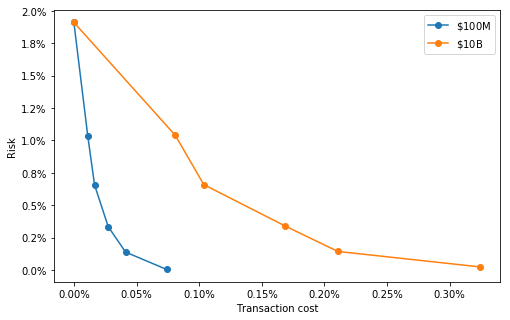

In [22]:
plt.figure(figsize=(8,5))
for v1 in table.index.levels[0][:]:
    x = table.loc[v1]['Trans. costs']
    y = table.loc[v1]['Active risk']
    plt.plot(np.array(x),np.array(y), 'o-', label='$%s\mathrm{%s}$'%(v1[:-1],v1[-1:]))
plt.legend(loc='upper right')
plt.xlabel('Transaction cost')
plt.ylabel('Risk')

import matplotlib.ticker as mtick
ax = plt.gca()
ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f%%'))
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1f%%'))
#plt.savefig(plotdir+'basic_frontier.png')